In [4]:
%cd ~/code/projects/nn-play/

import keras 
from keras.models import Model, Sequential
from keras.layers import Input, Dense
from keras.optimizers import Adam, Adadelta, RMSprop, SGD
from keras.layers import Input, Dense, Convolution2D, Deconvolution2D, MaxPooling2D,\
    UpSampling2D, Merge, LSTM, Flatten, ZeroPadding2D, Reshape, BatchNormalization, Dropout
from keras.layers.wrappers import TimeDistributed

from structured_container import DataContainer
from hydranet import HydraNet, EP_LEN, BATCH_SIZE

import tqdm
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

/home/ira/code/projects/nn-play


In [5]:
# load data
# exp_folder = "bounce_random-17-09-02_10:38"
exp_folder = "bases-0shift-17-09-04_15:21"
train_path = 'experiments/{}/data/train.pt'.format(exp_folder)
valid_path = 'experiments/{}/data/test.pt'.format(exp_folder)
train_box = DataContainer(train_path, batch_size=BATCH_SIZE, ep_len_read=EP_LEN)
valid_box = DataContainer(valid_path, batch_size=BATCH_SIZE, ep_len_read=EP_LEN)

v_size = 128
net = HydraNet()
net.load_modules('experiments/{}/modules'.format(exp_folder), tag='{}'.format(v_size))

Loading experiments/bases-0shift-17-09-04_15:21/data/train.pt
Loading experiments/bases-0shift-17-09-04_15:21/data/test.pt
Loading encoder from experiments/bases-0shift-17-09-04_15:21/modules/encoder-128.hdf5
Loading decoder from experiments/bases-0shift-17-09-04_15:21/modules/decoder-128.hdf5
Loading state_pred_train from experiments/bases-0shift-17-09-04_15:21/modules/state_pred_train-128.hdf5
Loading error_pred from experiments/bases-0shift-17-09-04_15:21/modules/error_pred-128.hdf5


In [6]:
ep = valid_box.get_n_random_episodes(1)
i = 0
ep.shape

(1, 120, 28, 28, 1)

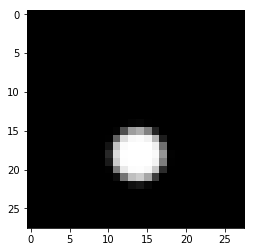

In [7]:
# x_t = x_t.reshape((1, 28, 28, 1))
# x_hat = stepper.predict(x_t*0)
plt.imshow(ep[0,i,:,:,0], cmap='gray', vmin=0.0, vmax=1.0)
i += 1

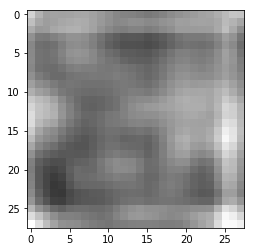

In [8]:
im, _ = net.stepper.predict(0*ep[:,i,...])
im = im/np.max(im)
plt.imshow(im[0,:,:,0], cmap='gray', vmin=0.0, vmax=1.0)

In [115]:
plt.ion()
errors = []
states = []

for i in range(120):
    ep = train_box.get_n_random_episodes(1)
    net.stepper.reset_states()

    for t in range(EP_LEN-1):
        if t < 7:
            ep_pred, state = net.stepper.predict(ep[:,t,...])
            error = np.mean((ep[:,t+1,...] - ep_pred)**2)
            errors.append(error)
            states.append(state)
        else:
            if np.random.rand() < 0.97:
                mask = 0
            else:
#                 print('Update!')
                mask = 1

            ep_pred, state = net.stepper.predict(mask * ep[:,t,...])
            error = np.mean((ep[:,t+1,...] - ep_pred)**2)
            errors.append(error)
            states.append(state)

    #     print('Error:', error)
    #     ep_pred_norm = ep_pred/np.max(ep_pred)
    #     im = np.concatenate([ep[:,t+1,...], ep_pred_norm], axis=2)
    #     plt.imshow(im[0,:,:,0], cmap='gray', vmin=0.0, vmax=1.0)
    #     plt.show()
    #     plt.pause(0.1)

#     plt.ioff()        

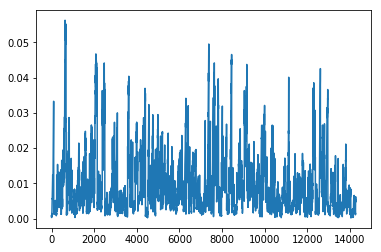

In [116]:
plt.plot(errors)

In [117]:
states_na = np.array(states).reshape(len(states), 128)
errors_na = np.array(errors).reshape((len(errors), 1))
# states_na.shape
net.err_pred.train_on_batch(states_na, errors_na)
# net.err_pred.fit(states_na, errors_na, batch_size=2)#, epochs=10)

5.2306426e-05

In [120]:
for i in range(1000):
    net.err_pred.train_on_batch(states_na, errors_na)
net.err_pred.train_on_batch(states_na, errors_na)

1.4506611e-05

In [183]:
# plt.ion()
errors = []
error_preds = []
states = []

ep = valid_box.get_n_random_episodes(1)
net.stepper.reset_states()

for t in range(EP_LEN-1):
    if t < 7:
        ep_pred, state = net.stepper.predict(ep[:,t,...])
        error = np.mean((ep[:,t+1,...] - ep_pred)**2)
        error_preds.append(net.err_pred.predict(state))
        errors.append(error)
        states.append(state)
    else:
        if np.random.rand() < 10.5:
            mask = 0
        else:
#             print('Update!')
            mask = 1

        ep_pred, state = net.stepper.predict(mask * ep[:,t,...])
        error = np.mean((ep[:,t+1,...] - ep_pred)**2)
        errors.append(error)
        error_preds.append(net.err_pred.predict(state))
        states.append(state)

#     print('Error:', error)
#     ep_pred_norm = ep_pred/np.max(ep_pred)
#     im = np.concatenate([ep[:,t+1,...], ep_pred_norm], axis=2)
#     plt.imshow(im[0,:,:,0], cmap='gray', vmin=0.0, vmax=1.0)
#     plt.show()
#     plt.pause(0.1)

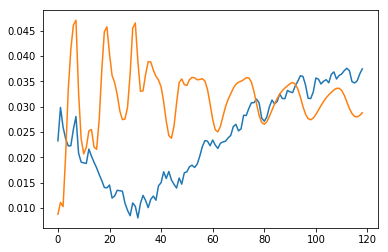

In [184]:
plt.plot(errors)
plt.plot(np.array(error_preds).flatten())

In [57]:
net.err_pred.predict(state)

array([[ 0.01841557]], dtype=float32)